# Detecting voice number ranges with quality issues
## A machine learning approach

**Omar Rubio - 20/07/2020** 

In [102]:
%matplotlib inline

########################################################################################################
#
# Import libraries
#
########################################################################################################
 
from sklearn.preprocessing import StandardScaler, Normalizer
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pyod.models.mo_gaal import MO_GAAL

In [103]:
########################################################################################################
#
# Input vector file
#
########################################################################################################
IN_VECTOR_PATH = r'C:\Traces\_Anomaly Detection'
IN_VECTOR_FILE = 'sip_vectors.csv'

########################################################################################################
#
# Input outlier file
#
########################################################################################################
IN_OUTLIER_PATH = r'C:\Traces\_Anomaly Detection'
IN_OUTLIER_FILE = 'outliers.xls'
IN_OUTLIER_SHEET = 'Outlier algorithm result'

# What problem are we trying to solve?

This is a sample of the actual performance of VM UK C20 route, used for international calls:
***
**Date**: 14/07/2020,  **NE Name**: BAGU-GMSS-1,   **Office**: LABEL=BAGU-C20-OFC, OFFICEDIR=1
***
- **Answer Rate (%) (24 hr)**: 83.727,   **"Answer Times (24 hr)"**: 500738,   **Answer Traffic (Erl, Max of 24 hr)**: 2279.8
- **Average Call Setup Times (24 hr)**: 3.447,   **Call Setup Time (24 hr)**: 1942212
- **Call Completion Rate (%) (24 hr)**: 99.75,   **Call Completion Traffic (Erl, Max of 24 hr)**: 2408.13
- **MSC OUTGOING SEIZURE SUCCESS RATE (%) (24 hr)**: 100,   **Seizure Traffic (Erl, Max of 24 hr)**: 2457.8,
- **Seizure Times (24 hr)**: 598059,   **Seizure Attempts times (24 hr)**: 598059
***
Overall is a good performance.

## **Can I say the same about calls to FR? DE? ...**

In [104]:
TIME_FIELDS = ['Start timestamp', 'Setup Time', 'Answer Time', 'Call Duration', 'ST Valid', 'AT Valid']

# Reads vectors
df_all = pd.read_csv(os.path.join(IN_VECTOR_PATH, IN_VECTOR_FILE), delimiter = '\t')
df_all['Start timestamp'] = pd.to_datetime(df_all['Start timestamp'], unit='s')
#df = df_all.loc[:,TIME_FIELDS[1]:]
df = df_all

# Reads outliers
df_out = pd.read_excel(os.path.join(IN_OUTLIER_PATH, IN_OUTLIER_FILE), sheet_name = IN_OUTLIER_SHEET)

[]

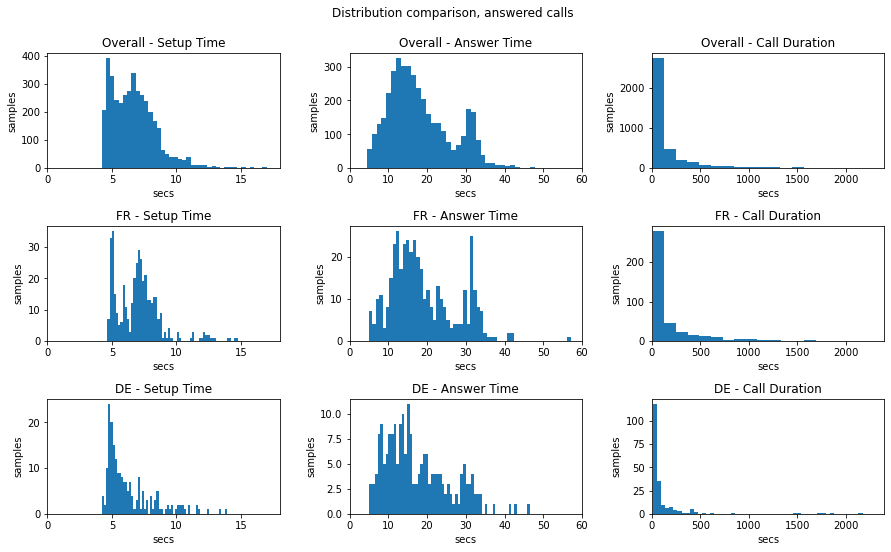

In [105]:
n_bins = 60
countries = ['Overall', 'FR', 'DE']
country_code = {'Overall':'+', 'FR':'+33', 'DE':'+49'}
column_title = ['Setup Time', 'Answer Time', 'Call Duration']
limits = [(0, 18), (0, 60), (0, 2400)]

fig, axes = plt.subplots(nrows = len(countries), ncols = len(column_title), 
                         squeeze = False, figsize=(15, 8))
fig.subplots_adjust(wspace=0.3, hspace=0.5, left=0.125, right=0.9, top=0.9, bottom=0.1)
fig.suptitle('Distribution comparison, answered calls')

for i, row in enumerate(countries):
    for j, column in enumerate(column_title):
        axes[i, j].set_title(' - '.join([countries[i], column_title[j]]))
        axes[i, j].set_xlim(*limits[j])
        country_columns = df.columns[df.columns.str.contains('\\' + country_code[countries[i]])]
        df_result = df[country_columns].loc[df[country_columns].any(axis=1), country_columns]
        df_result['AT Valid'] = df['AT Valid'].where(df[country_columns].any(axis=1)).dropna()
        df_result[column_title[j]] = df[column_title[j]].where(df[country_columns].any(axis=1)).dropna()
#        df_result = df_result[df_result[column_title[j]] < 900]
        df_result = df_result[df_result['AT Valid'] > 0]
        df_result[column_title[j]].plot.hist(bins = n_bins, ax = axes[i, j], subplots=True)

# Set labels
for ax in axes.flat:
    ax.set(xlabel='secs', ylabel='samples')

# Hide x labels and tick labels for top plots and y ticks for right plots.
#for ax in axes.flat:
#    ax.label_outer()
plt.plot()

# Detailed analysis takes time

- Multiple counters and KPIs need to be checked
- Even if only top ten destinations are considered, still time consuming
- Top ten destinations change, so you need to adjust accordingly
- The result is usually that all is OK (hopefully)
  - If it is not, means that the behaviour of many calls differ from the overall data distribution
  - The task is then finding **outliers**. If there are too many in a number range, we've got a problem there

# Welcome to machine learning (ML)!
- Machine learning aims to perform a task by learning from data instead of explicit rule programming
- The task in our case is to find outliers in number ranges

## Outlier detection algorithms
- Algorithms capable of detecting data examples which deviate from a data distribution

## Advantages of this approach
- No need to explicitly define ranges to track
- Capable of discovering faults in ranges with small traffic volumes
- Analyst focuses on abnormal behaviour rather than confirming normal behaviour
- Methodology can be extended to SMS and data

## Disadvantages of this approach
- Results from algorithm require manual interpretation:
  - Basics of statistics
  - Fluency with Python and data analysis packages
- Reliance on tracing tools (Polystar)
- Special hardware require(GPU) to run algorithms fast

# The anomaly detection process

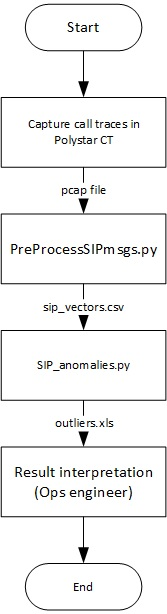

In [106]:
def plot_comparison(countries, country_code, column_title, limits):
    ''' Plots comparison between two call distributions '''
    fig, axes = plt.subplots(nrows = len(countries), ncols = len(column_title), 
                             squeeze = False, figsize=(15, 8))
    fig.subplots_adjust(wspace=0.5, hspace=0.5, left=0.125, right=0.9, top=0.9, bottom=0.1)
    fig.suptitle('Distribution comparison')

    for i, row in enumerate(countries):
        for j, column in enumerate(column_title):
            axes[i, j].set_title(' - '.join([countries[i], column_title[j]]))
            axes[i, j].set_xlim(*limits[j])
            # Full distribution
            country_columns = df.columns[df.columns.str.contains('\\' + country_code[countries[i]])]
            valid_rows = df[country_columns].any(axis=1)
            df_result = df[country_columns].loc[valid_rows, country_columns]
            df_result['ST Valid'] = df['ST Valid'].where(valid_rows).dropna()
            df_result['AT Valid'] = df['AT Valid'].where(valid_rows).dropna()
            df_result[column_title[j]] = df[column_title[j]].where(valid_rows).dropna()
            # Outlier distribution
            country_columns = df_out.columns[df_out.columns.str.contains('\\' + country_code[countries[i]])]            
            valid_rows = df_out[country_columns].any(axis=1)
            df_from_out = df_out[country_columns].loc[valid_rows, country_columns]
            df_from_out['ST Valid'] = df_out['ST Valid'].where(valid_rows).dropna()
            df_from_out['AT Valid'] = df_out['AT Valid'].where(valid_rows).dropna()
            df_from_out[column_title[j]] = df_out[column_title[j]].where(valid_rows).dropna()            
            if (column_title[j] == 'ST Valid'):
                (df_result['ST Valid'].value_counts()).plot.bar(stacked = True, ax = axes[i, j])
                (df_from_out['ST Valid'].value_counts()).plot.bar(stacked = True, ax = axes[i, j], color = 'r')
            else:
                if (column_title[j] == 'Setup Time'):
                    df_result = df_result[df_result['ST Valid'] > 0]
                    df_from_out = df_from_out[df_from_out['ST Valid'] > 0]
                elif (column_title[j] == 'Answer Time'):
                    df_result = df_result[df_result['AT Valid'] > 0]
                    df_from_out = df_from_out[df_from_out['AT Valid'] > 0]
                df_result[column_title[j]].plot.hist(bins = n_bins, ax = axes[i, j], subplots=True)
                df_from_out[column_title[j]].plot.hist(bins = n_bins, ax = axes[i, j], subplots=True, color = 'r')

    # Set labels
    #for ax in axes.flat:
    #    ax.set(xlabel='secs', ylabel='samples')

    # Hide x labels and tick labels for top plots and y ticks for right plots.
    #for ax in axes.flat:
    #    ax.label_outer()
    plt.plot()

def retrieve_outliers(num_range):
    columns = df_out.columns[df_out.columns.str.contains('\\' + num_range)]  
    cause_cols = df_out.columns[df_out.columns.str.contains('Q.850;cause=')]
#    df_cause = df_out.loc[df_out[cause_cols].any(axis=1), cause_cols]
    range_df = df_out.loc[:, columns]
    range_df['ST Valid'] = df_out['ST Valid']
    range_df['AT Valid'] = df_out['AT Valid']
    range_df['Start timestamp'] = df_out['Start timestamp']
#    range_df = pd.concat([range_df, df_cause], axis=1)
    print(range_df.loc[df_out.loc[df_out[columns].any(axis=1), columns].index].dropna())

In [107]:
n_bins = 60
countries = ['Overall', num_range]
country_code = {'Overall':'+', '+3278':'+3278', '+3279':'+3279', '+3365':'+3365', '+4917':'+4917', '+3519':'+3519',
               '+4860':'+4860', '+3538':'+3538', '+4074':'+4074', '+4075':'+4075'}
column_title = ['ST Valid', 'Setup Time', 'Answer Time', 'Call Duration']
limits = [(0, 2), (0, 18), (0, 50), (0, 2400)]

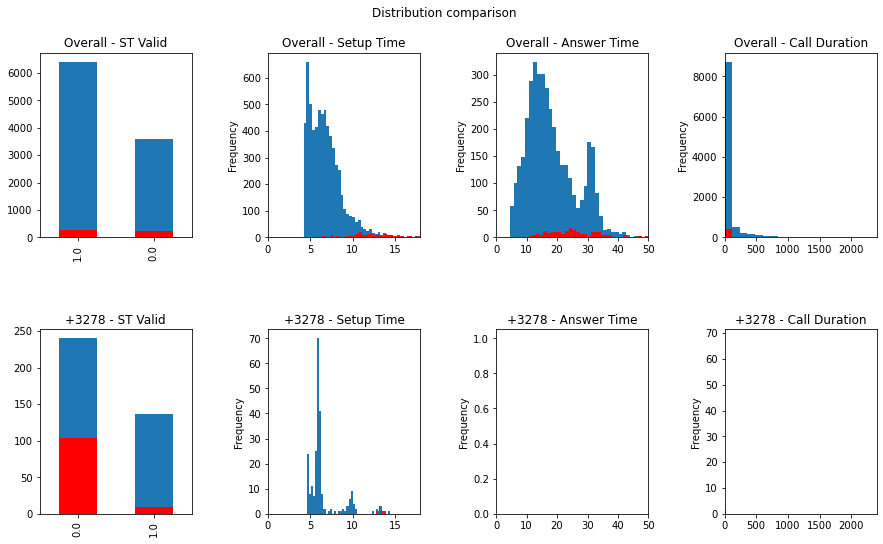

In [108]:
num_range = '+3278'
countries = ['Overall', num_range]

plot_comparison(countries, country_code, column_title, limits)

In [109]:
retrieve_outliers(num_range)

        +3278  ST Valid  AT Valid     Start timestamp
45   0.872493       1.0       0.0 2020-07-06 20:40:55
181  0.895461       1.0       0.0 2020-07-06 13:28:34
219  0.885341       1.0       0.0 2020-07-06 13:07:59
231  0.885341       1.0       0.0 2020-07-08 15:31:04
232  0.895461       1.0       0.0 2020-07-06 21:17:49
..        ...       ...       ...                 ...
425  0.894938       0.0       0.0 2020-07-06 15:01:40
426  0.896898       0.0       0.0 2020-07-07 13:41:22
427  0.894938       0.0       0.0 2020-07-06 13:28:31
428  0.894938       0.0       0.0 2020-07-06 13:13:43
431  0.894938       0.0       0.0 2020-07-08 07:37:35

[112 rows x 4 columns]


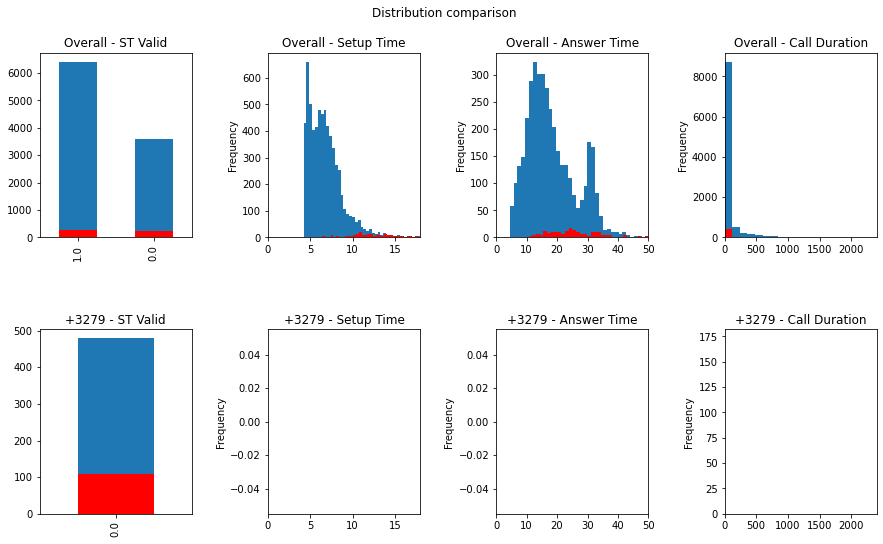

In [110]:
num_range = '+3279'
countries = ['Overall', num_range]

plot_comparison(countries, country_code, column_title, limits)

In [111]:
retrieve_outliers(num_range)

        +3279  ST Valid  AT Valid     Start timestamp
288  0.886397       0.0       0.0 2020-07-08 11:36:44
291  0.886397       0.0       0.0 2020-07-07 22:31:15
293  0.886397       0.0       0.0 2020-07-08 08:50:47
295  0.886397       0.0       0.0 2020-07-06 17:50:12
296  0.886397       0.0       0.0 2020-07-07 12:09:08
..        ...       ...       ...                 ...
494  0.884276       0.0       0.0 2020-07-06 15:59:08
495  0.884276       0.0       0.0 2020-07-06 15:07:16
496  0.884276       0.0       0.0 2020-07-06 14:06:18
497  0.884276       0.0       0.0 2020-07-06 12:59:15
498  0.884276       0.0       0.0 2020-07-06 11:35:14

[108 rows x 4 columns]


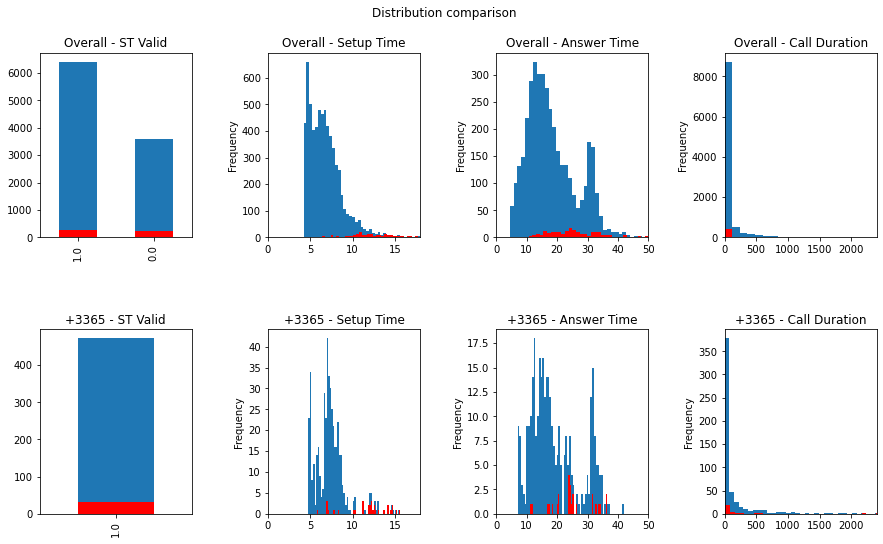

In [112]:
num_range = '+3365'
countries = ['Overall', num_range]

plot_comparison(countries, country_code, column_title, limits)

In [113]:
retrieve_outliers(num_range)

        +3365  ST Valid  AT Valid     Start timestamp
28   0.793639       1.0       1.0 2020-07-06 12:42:05
32   0.819049       1.0       1.0 2020-07-06 16:42:55
33   0.802175       1.0       1.0 2020-07-06 16:17:44
63   0.878451       1.0       1.0 2020-07-07 10:14:55
69   0.878451       1.0       1.0 2020-07-07 13:24:29
76   0.606789       1.0       1.0 2020-07-07 12:25:30
83   0.879586       1.0       1.0 2020-07-06 16:32:26
84   0.849244       1.0       1.0 2020-07-06 17:48:56
95   0.505818       1.0       1.0 2020-07-07 07:45:13
100  0.878451       1.0       1.0 2020-07-07 08:52:49
112  0.593496       1.0       1.0 2020-07-06 19:36:23
113  0.879586       1.0       1.0 2020-07-06 17:46:02
119  0.605501       1.0       1.0 2020-07-07 11:41:58
120  0.647317       1.0       1.0 2020-07-07 16:16:00
122  0.849244       1.0       1.0 2020-07-06 16:37:48
133  0.621838       1.0       1.0 2020-07-07 08:15:16
136  0.879586       1.0       1.0 2020-07-07 09:23:59
143  0.546087       1.0     

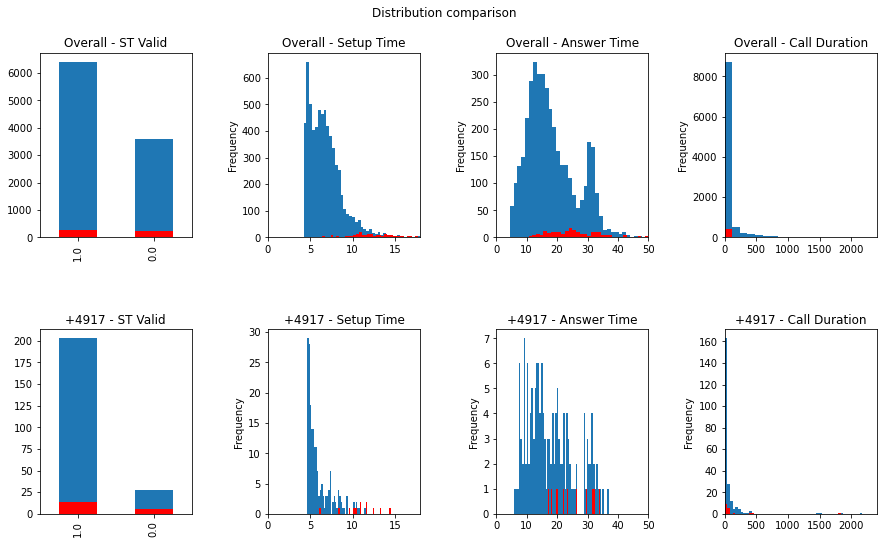

In [114]:
num_range = '+4917'
countries = ['Overall', num_range]

plot_comparison(countries, country_code, column_title, limits)

In [115]:
retrieve_outliers(num_range)

        +4917  ST Valid  AT Valid     Start timestamp
54   0.695350       1.0       1.0 2020-07-08 09:32:17
108  0.911456       1.0       1.0 2020-07-07 16:13:55
116  0.906694       1.0       1.0 2020-07-07 08:14:19
137  0.903954       1.0       1.0 2020-07-07 10:35:36
147  0.544355       1.0       1.0 2020-07-06 14:42:24
157  0.906153       1.0       1.0 2020-07-06 15:42:17
164  0.876454       1.0       1.0 2020-07-08 12:43:48
176  0.911456       1.0       1.0 2020-07-07 07:49:18
180  0.904543       1.0       1.0 2020-07-07 08:05:07
183  0.963487       1.0       1.0 2020-07-06 22:11:25
193  0.560584       1.0       0.0 2020-07-07 08:33:48
195  0.915718       1.0       1.0 2020-07-06 14:29:33
201  0.881740       1.0       1.0 2020-07-06 11:53:31
229  0.904543       1.0       1.0 2020-07-08 14:58:16
263  0.914454       0.0       0.0 2020-07-06 16:59:35
267  0.914454       0.0       0.0 2020-07-07 10:13:49
403  0.895645       0.0       0.0 2020-07-06 11:52:57
405  0.895645       0.0     

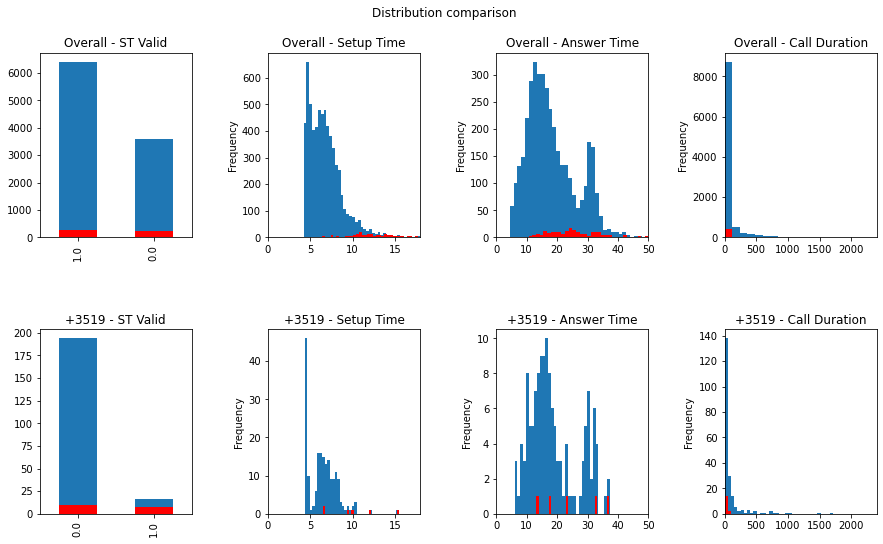

In [116]:
num_range = '+3519'
countries = ['Overall', num_range]

plot_comparison(countries, country_code, column_title, limits)

In [117]:
retrieve_outliers(num_range)

        +3519  ST Valid  AT Valid     Start timestamp
9    0.914760       1.0       1.0 2020-07-06 19:11:53
96   0.867545       1.0       1.0 2020-07-06 15:48:54
125  0.919090       1.0       0.0 2020-07-08 09:18:02
144  0.967958       1.0       1.0 2020-07-06 19:19:14
184  0.907447       1.0       1.0 2020-07-06 12:56:32
189  0.905465       1.0       1.0 2020-07-08 11:37:06
230  0.914760       1.0       1.0 2020-07-08 17:16:40
278  0.967742       0.0       0.0 2020-07-07 13:16:00
300  0.917364       0.0       0.0 2020-07-08 15:56:17
302  0.917364       0.0       0.0 2020-07-07 11:30:28
303  0.968028       0.0       0.0 2020-07-07 14:25:45
310  0.917364       0.0       0.0 2020-07-06 18:24:54
321  0.917364       0.0       0.0 2020-07-06 16:59:49
326  0.917364       0.0       0.0 2020-07-06 18:17:24
361  0.918042       0.0       0.0 2020-07-07 20:16:22
401  0.918042       0.0       0.0 2020-07-06 19:37:09
429  0.918042       0.0       0.0 2020-07-08 10:55:04


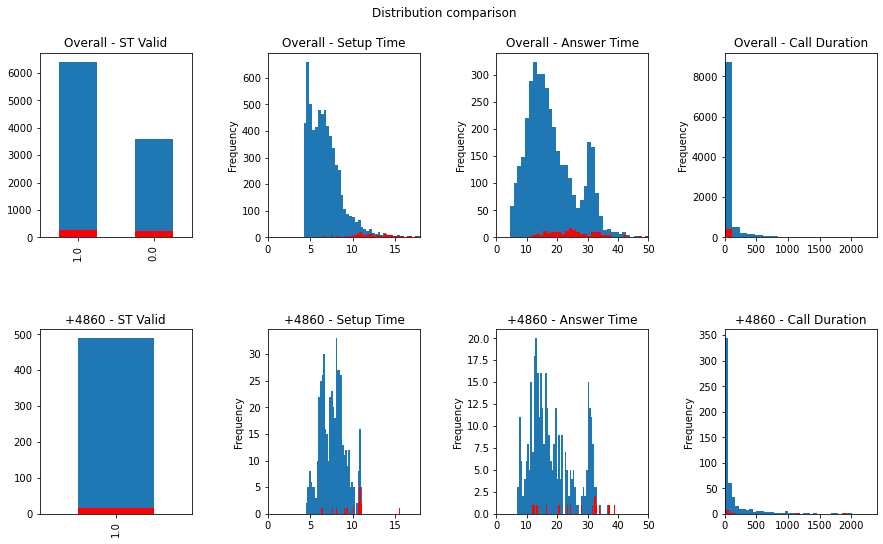

In [118]:
num_range = '+4860'
countries = ['Overall', num_range]

plot_comparison(countries, country_code, column_title, limits)

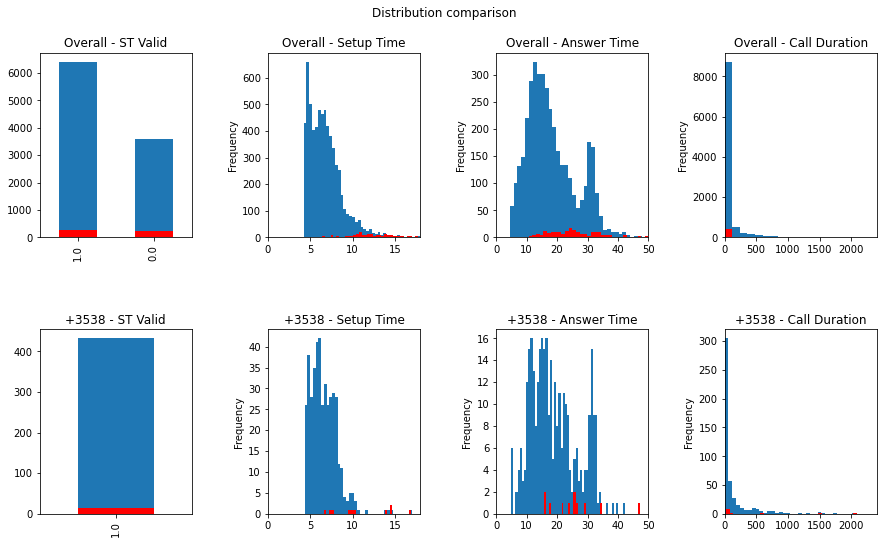

In [119]:
num_range = '+3538'
countries = ['Overall', num_range]

plot_comparison(countries, country_code, column_title, limits)

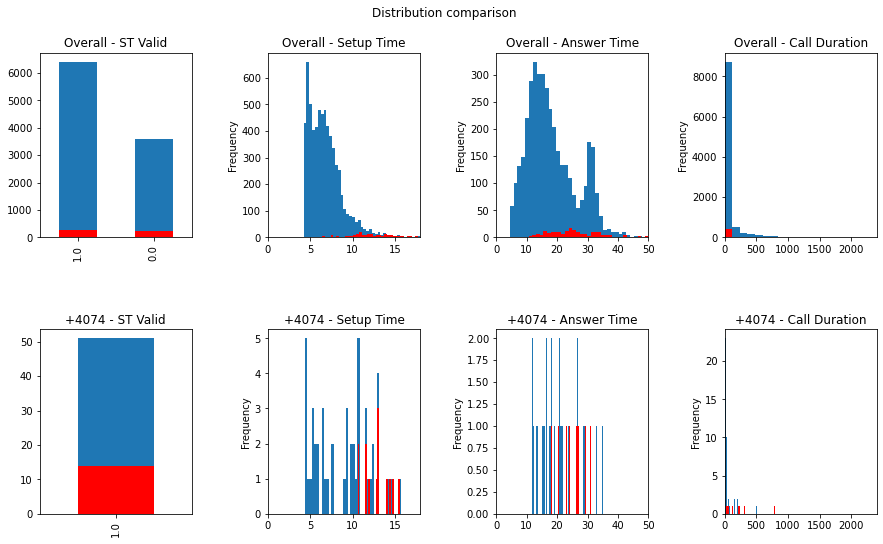

In [120]:
num_range = '+4074'
countries = ['Overall', num_range]

plot_comparison(countries, country_code, column_title, limits)

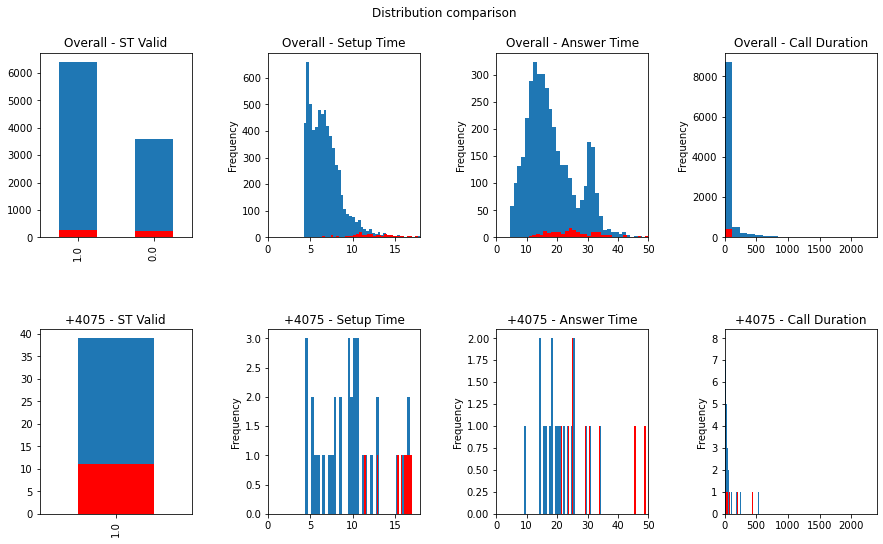

In [121]:
num_range = '+4075'
countries = ['Overall', num_range]

plot_comparison(countries, country_code, column_title, limits)